##### Social Media Analytics
### Introduction to Text Mining
## Frequency Analysis
(c) Nuno Antonio 2019-2022 v1.02

### Initial setup

In [32]:
# Import packages
import csv
import pandas as pd
import numpy as np
import nltk 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# Load dataset
ds = pd.DataFrame(pd.read_excel("https://github.com/felix-funes/social-media-analytics/blob/main/iphone-subreddit-comments.xlsx?raw=true"))

## Data Preparation

In [34]:
# We check for missing values in the body column
print(ds['body'].isna().sum())

3


In [35]:
# We replace the missing values with an empty string
ds['body'] = ds['body'].fillna('')

In [36]:
# We check for URLs in the body column

# Define regular expression pattern to match URLs
url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

# Define function to remove URLs from text
def remove_urls(text):
    return url_pattern.sub('', text)

# Apply the function to the 'body' column of the 'body' dataframe
ds['body'] = ds['body'].apply(remove_urls)

In [37]:
# Count the number of rows with 'AutoModerator' in the 'author' column
num_automod = len(ds[ds['author'] == 'AutoModerator'])
num_automod

5

In [38]:
# Remove rows with 'AutoModerator' in the 'author' column
ds = ds[ds['author'] != 'AutoModerator']

### Functions

In [39]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    if type(rawText) != str:
        return rawText
    procText = rawText
        
    # Remove HTML
    if removeHTML:
        procText = BeautifulSoup(procText,'html.parser').get_text()

    # Remove punctuation and other special characters
    if len(charsToRemove)>0:
        procText = re.sub(charsToRemove,' ',procText)

    # Remove numbers
    if removeNumbers:
        procText = re.sub(r'\d+',' ',procText)

    # Remove line breaks
    if removeLineBreaks:
        procText = procText.replace('\n',' ').replace('\r', '')

    # Remove special characters
    if len(specialCharsToRemove)>0:
        procText = re.sub(specialCharsToRemove,' ',procText)

    # Normalize to lower case
    if convertToLower:
        procText = procText.lower() 

    # Replace multiple consecutive spaces with just one space
    if removeConsecutiveSpaces:
        procText = re.sub(' +', ' ', procText)

    return procText

In [40]:
# Tokenize words
def tokenize_words(words):
    if (type(words) != str) or (word_tokenize(words) == ''):
        return np.nan
    else:
        return word_tokenize(words)

In [41]:
# Stemm texts
def stemming(words):
    stemmed_word = [snowball.stem(x) for x in (words[:])]
    return stemmed_word

In [42]:
# Function to count the frequency of n-grams (Adapted from https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)
# Uses CountVectorizer from sklearn instead of FreqDist from NLTK
def get_top_n_words(corpus, n=None, nGrams=1): 
    vec = CountVectorizer(max_df=0.8, stop_words=stop_words,ngram_range=(nGrams,nGrams), max_features=10000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Analysis

In [43]:
# Create a dataframe with only the description
processedReviews =  pd.DataFrame(data=ds.body.apply(textPreProcess).values, index=ds.index, columns=['PreProcessedText']) 

c:\Users\Felix\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [44]:
# Tokenize text
processedReviews['Words'] =  processedReviews['PreProcessedText'].apply(tokenize_words)

In [45]:
# Compute terms frequency distribution

from nltk.probability import FreqDist

fdist = FreqDist()

for review in processedReviews.Words:
    if review is not None and isinstance(review, list): # Check if the review is not null and is a list
        for term in review:
            fdist[term] += 1

In [46]:
# Transform results to a sorted dataframe
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [47]:
# Top 15
df_fdist.head(15)

,Frequency
Term,
the,997
i,820
it,678
to,629
and,542
a,534
you,435
is,336
that,295


In [48]:
# Low 15
df_fdist.tail(15)

,Frequency
Term,
microscratches,1
th,1
theft,1
condition,1
san,1
pristine,1
surprisingly,1
thingy,1
test,1


In [49]:
# Remove stopwords and re-explore results
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)]
df_fdist.head(15)

,Frequency
Term,
phone,253
iphone,190
apple,106
esim,106
photos,99
get,85
's,84
new,75
like,70


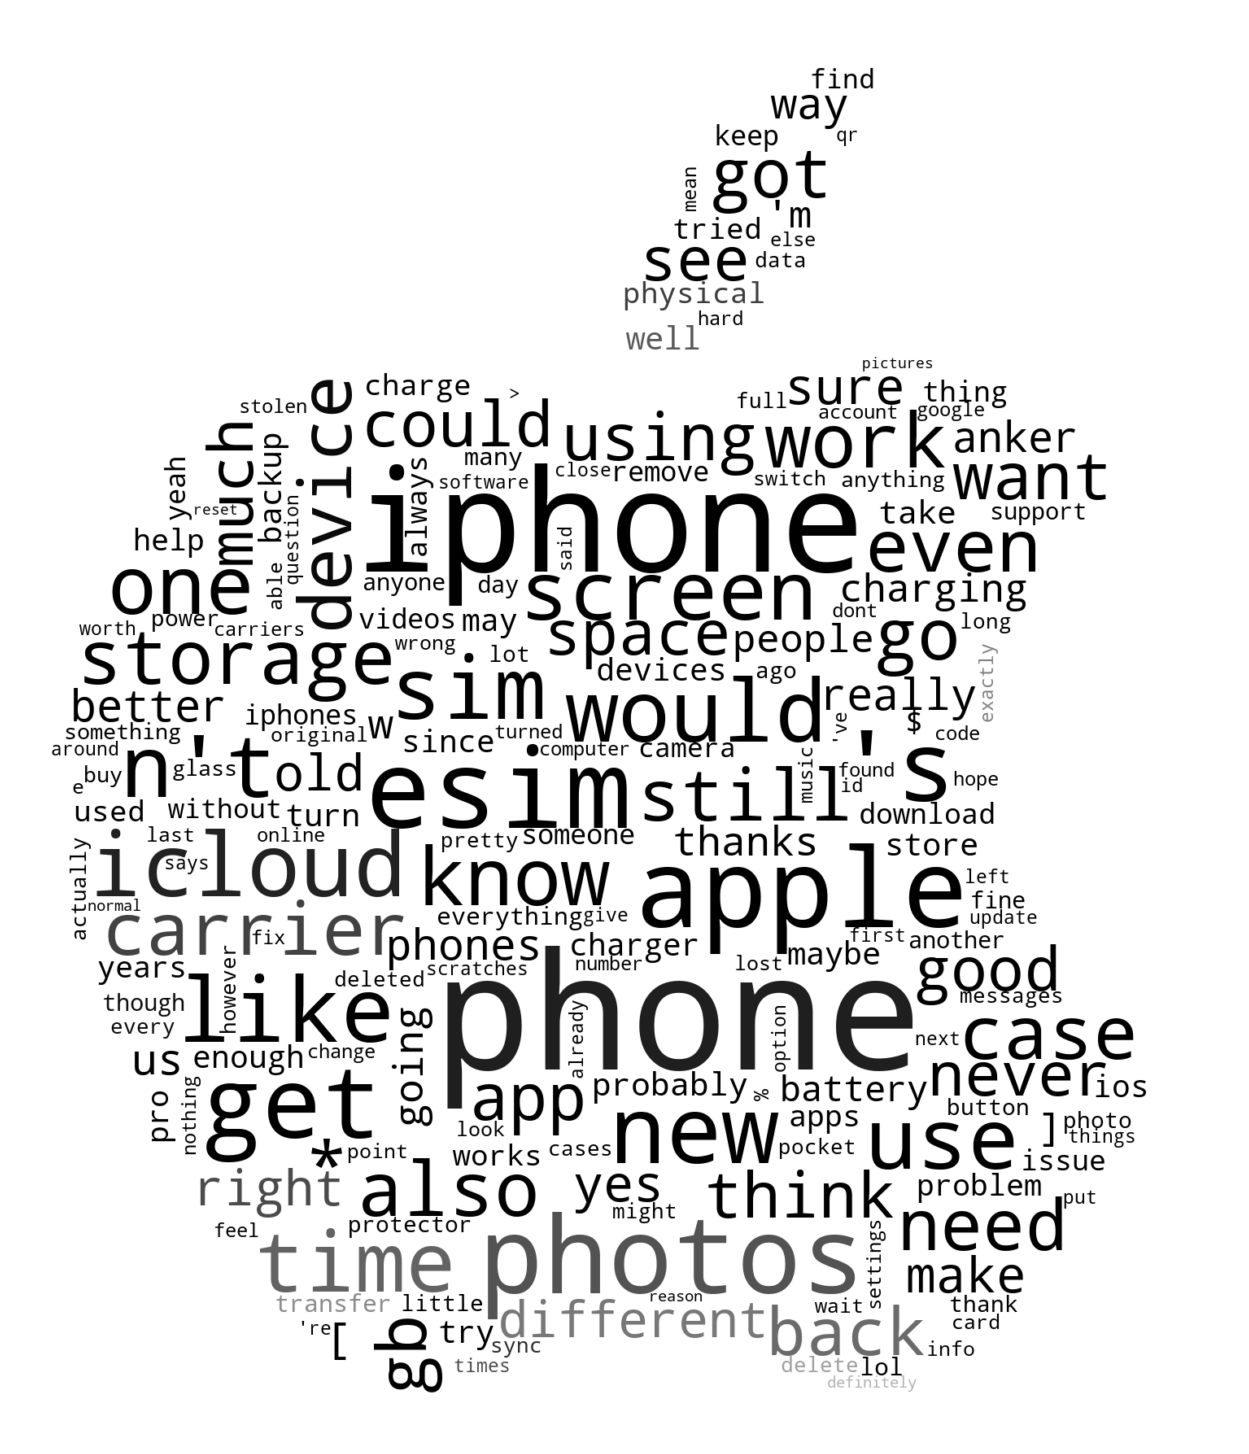

In [50]:
# Plot a wordcloud
# Set stopwords
stop_words = set(stopwords.words('english'))

# Convert the dataframe to a dictionary
word_freq = df_fdist['Frequency'].to_dict()

# Define a function to create a wordcloud image
def create_wordcloud(all_words_lem, mask_path, save_path):
    mask = np.array(Image.open(mask_path))
    stopwords = set(STOPWORDS).union(stop_words)

    wordcloud = WordCloud(height=500,
                          width=500,
                          background_color="white",
                          min_font_size=10,
                          max_font_size=200,
                          mode="RGBA",
                          stopwords=stopwords,
                          mask=mask).generate_from_frequencies(all_words_lem)

    # Create coloring from the image
    image_colors = ImageColorGenerator(mask)

    # Plot the word cloud image
    plt.figure(figsize=[20,20])
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")

    # Save the word cloud image
    plt.savefig(save_path, format="png")
    plt.show()

# Download the image from the URL and save it to a local file
response = requests.get('https://github.com/Alito06/FinalProjectSMA/blob/main/Apple-logo-black-and-white.png?raw=true')
img = Image.open(BytesIO(response.content))
img.save('apple_logo.png')

# Load the text to be used to create the wordcloud
all_words_lem = word_freq

# Create the wordcloud using the apple logo as a mask
create_wordcloud(all_words_lem, 'apple_logo.png', 'apple_wordcloud_1.png')

In [51]:
# Create a stemmed version of the words to normalize the Lexicon
# Import package
from nltk.stem import SnowballStemmer

In [52]:
# Check languages supported
print(" ".join(SnowballStemmer.languages))

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [53]:
# Define stemming function
def stemming(review):
    if isinstance(review, list): # Check if the review is a list
        return [snowball.stem(word) for word in review]
    else:
        return []

# Initialize SnowballStemmer object
snowball = SnowballStemmer("english")

# Create a new column for stemmed words
processedReviews['StemmedWords'] = processedReviews['Words'].apply(lambda x: stemming(x))

In [54]:
# Calculate frequency distributions of the stemmed words
fdist = FreqDist()
for review in processedReviews.StemmedWords:
  for term in review:
    fdist[term]+=1

# Create the sorted dataframe and sort it
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [55]:
# Remove the stopwords
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)] 

In [56]:
df_fdist

,Frequency
Term,
phone,282
iphon,209
use,130
photo,115
esim,113
...,...
tear,1
magnet,1
bewar,1


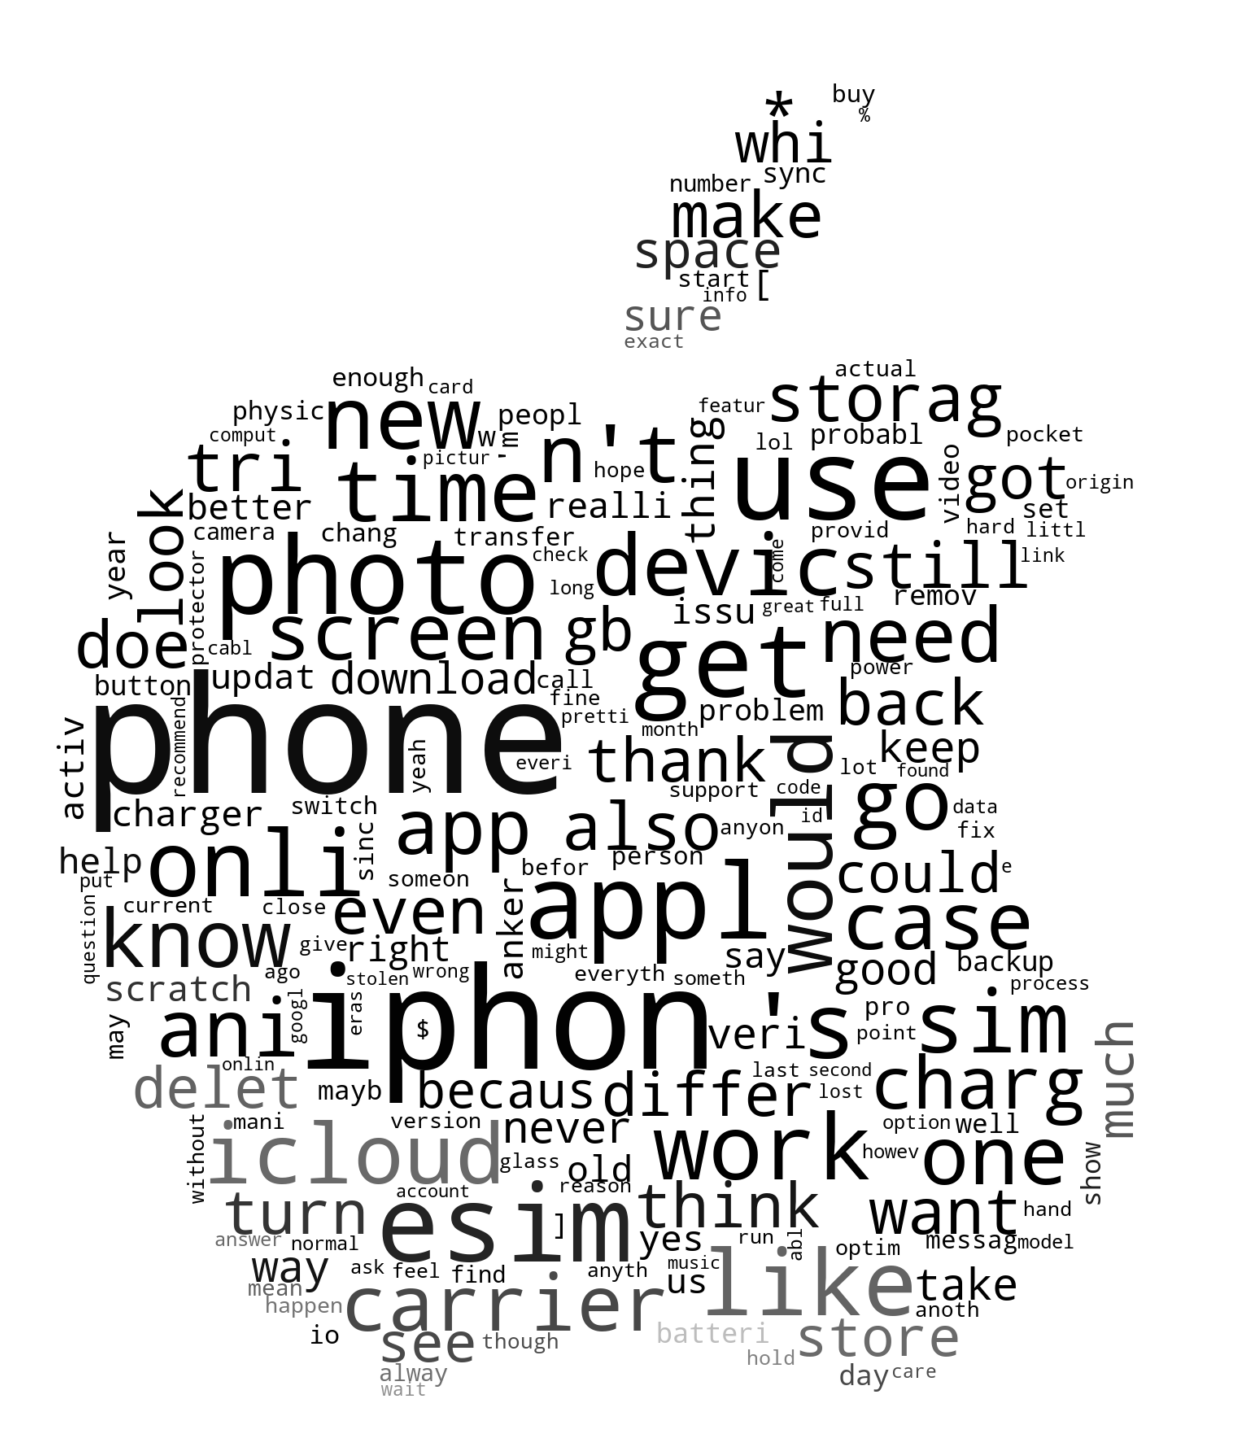

In [57]:
# Plot a new wordcloud with the stemmed words
# Set stopwords
stop_words = set(stopwords.words('english'))

# Convert the dataframe to a dictionary
word_freq = df_fdist['Frequency'].to_dict()

# Define a function to create a wordcloud image
def create_wordcloud(all_words_lem, mask_path, save_path):
    mask = np.array(Image.open(mask_path))
    stopwords = set(STOPWORDS).union(stop_words)

    wordcloud = WordCloud(height=500,
                          width=500,
                          background_color="white",
                          min_font_size=10,
                          max_font_size=200,
                          mode="RGBA",
                          stopwords=stopwords,
                          mask=mask).generate_from_frequencies(all_words_lem)

    # Create coloring from the image
    image_colors = ImageColorGenerator(mask)

    # Plot the word cloud image
    plt.figure(figsize=[20,20])
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")

    # Save the word cloud image
    plt.savefig(save_path, format="png")
    plt.show()

# Download the image from the URL and save it to a local file
response = requests.get('https://github.com/Alito06/FinalProjectSMA/blob/main/Apple-logo-black-and-white.png?raw=true')
img = Image.open(BytesIO(response.content))
img.save('apple_logo.png')

# Load the text to be used to create the wordcloud
all_words_lem = word_freq

# Create the wordcloud using the apple logo as a mask
create_wordcloud(all_words_lem, 'apple_logo.png', 'apple_wordcloud_2.png')

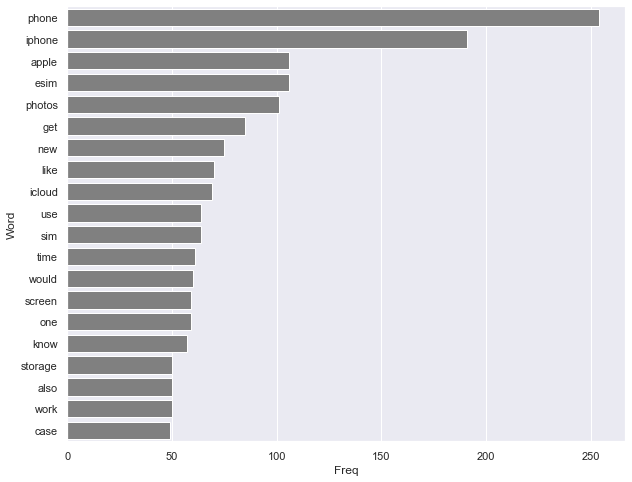

In [58]:
# PLOT top 20 most frequently occuring UNI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=1)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(10,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

Some relevant topics that we can see here are:
- New e-sim: "esim" and "sim"
- Storage: "icloud" and "storage" ("photos" could also be related to this topic)
- Durability: "case" and probably "screen"

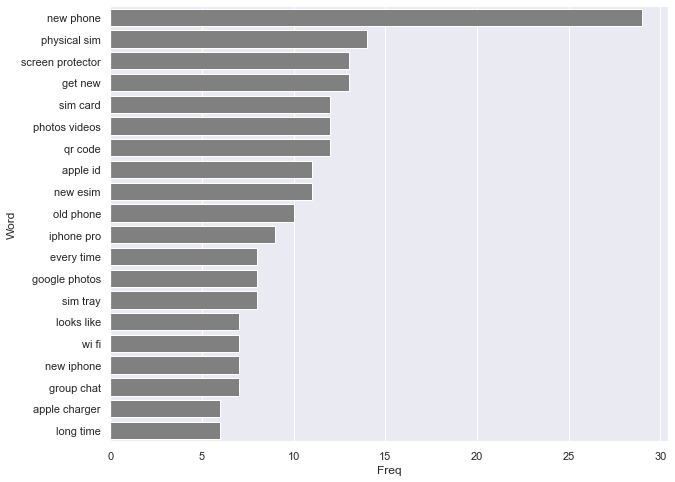

In [59]:
# PLOT top 20 most frequently occuring BI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=2)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(10,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

The iPhone 14 is one of the first phones to come without a physical SIM card, and this is clearly something of importance to users, since the term "physical SIM" is the second most used, "SIM card" the fifth and "new esim" the ninth. The term "qr code" is also likely related to this topic, since the new eSim is activated using a QR code.

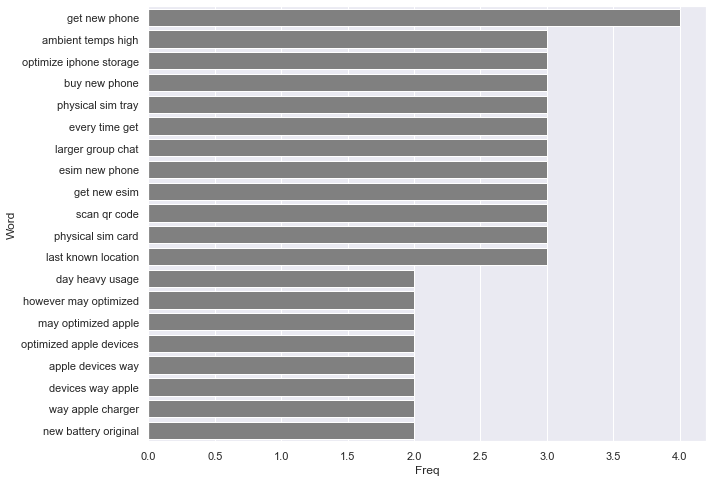

In [60]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=3)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(10,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")

The tri-grams reinforce our impressions from the bi-grams as regards the SIM cards, since terms like "physical sim tray", "esim new phone", "get new esim", "scan qr code" and "physical sim card" are among the most popular.

The tri-grams also let us identify another area of importance for users: battery. Terms such as "new battery original", "way apple charger", and "day heavy usage" give us some insight that this could be a trouble area for users. Also, the term "ambient temps high" seems to refer to the possibility of batteries heating up in high ambient temperatures.

Finally, storage seems to be another important area. Phrases like "optimize iphone storage" make this very clear, as well as some tri-grams that seem to be related, like "however may optimized", "may optimized apple", and "optimized apple devices". This could also be related to the bigram "google photos" that we saw before.